In [8]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [9]:
import my_libs as ml
from my_libs.tools import *
from my_libs.fft import *
from my_libs.colors import *
from my_libs.img import images
from my_libs.img.processing import *

In [10]:
ml.tools.printf("Hello world!")

Hello world!

## Cvičení 11

In [11]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

Naprogramujte  algoritmus  MACE.  Pro  trénování  (3  různí  lidé)  použijte obrázky (převedené do stupňů šedi) p11...p33.bmp (PVI_C11.ZIP). 
 
Pomocí  algoritmu  MACE  klasifikujte  neznámý  obraz  `unknown.bmp`. Strmost vrcholu ve výsledném obraze počítejte ze střední oblasti 20x20 ve které je vrchol v oblasti 10x10. 
 
Vykreslete  (v  jednom  okně)  neznámý  obrázek  a  jeden  z  obrázků klasifikované třídy. 

```python
vec = np.fft.fft2(imG).flatten() x np.fft.fft2(imG).flatten().reshape(4096,1) 
 
X = np.zeros((4096,3),dtype=complex) 
 
Xp = X.conjugate().transpose() 
 
Dm1 = np.linalg.inv(D) 
 
M0 = np.matmul(Dm1, X) 
 
A = np.abs(np.fft.ifft2(M)) 
```

In [12]:
folder = "data/"
uknown_file = "unknown.bmp"

# Filter images
picture_files = images.find(folder, "bmp")
picture_files.sort()

print("Images found: ")
#for picture_file in picture_files:
    #print(images.file_name(picture_file))

for i in range(len(picture_files)):
    if picture_files[i].find(uknown_file) != -1:
        picture_files.pop(i)
        break

number_of_images = len(picture_files)
print("Number of images: ", number_of_images)

# Load images
imgs = images.load(picture_files)

Current working directory: /home/vojta/PVI-Pocitacove_videni/cviceni/cv11, files: 
p33.bmp
unknown.bmp
p22.bmp
p23.bmp
p32.bmp
p11.bmp
p13.bmp
p21.bmp
p31.bmp
p12.bmp
Images found: 
Number of images:  9


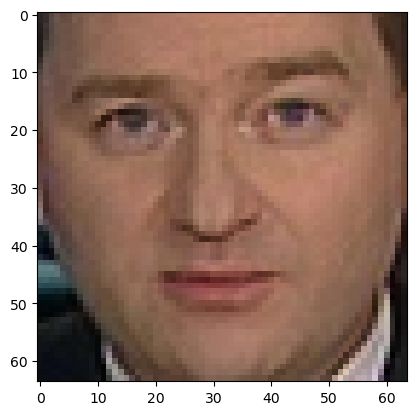

In [29]:
# Show unknown image
path = folder + uknown_file

# test if exists
if not os.path.exists(path):
    raise Exception("File not found: " + path)

unknown_image_bgr = cv.imread(folder + uknown_file)
unknown_image = cv.cvtColor(unknown_image_bgr, cv.COLOR_BGR2RGB)

# Načtení neznámého obrázku
unknown_img_gray = cv.cvtColor(unknown_image_bgr, cv.COLOR_BGR2GRAY)

plt.imshow(unknown_image)

## MACE filtr

In [14]:
from my_libs import fft

### Rozdelění do tříd

In [15]:
# rozdeleni obrazku do 3 trid
number_of_classes = 3
number_of_images_per_class = number_of_images // number_of_classes

clases = []
for i in range(number_of_classes):
    one_class = []
    for _ in range(number_of_images_per_class):
        one_class.append(imgs.pop(0))
    clases.append(one_class)

### Návrh filtru MACE:
$$
M = D^{-1}X(X^+D^{-1}X)^{-1}u
$$

- X – matice z vektorů: DFT počítaná z trénovacích obrazů, lexikograficky řazené
- X+ – matice transponovaná a komplexně sdružená k X
- u – sloupcový vektor, hodnoty obvykle 1 
- D – diagonální matice: hodnoty spočítané jako průměr výkonového spektra z řádků matice X

In [16]:
VERBOSE = True
def generate_mace_filter(imgs) -> np.ndarray:
    # Konvertovani do grayscale
    train_imgs = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in imgs]

    # Vytvoření trénovací matice
    X = np.array([np.fft.fft2(img).flatten() for img in train_imgs]).T

    # Vytvoření D diagonální matice: 
    # hodnoty spočítané jako průměr výkonového spektra z řádků matice X
    D = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        D[i, i] = np.mean(np.abs(X[i, :])**2)
    
    # 3x1 jednotkový vektor
    u = np.ones((len(imgs), 1))

    # Výpočet MACE filtru
    D_inv = np.linalg.inv(D)
    XH = X.conjugate().T
    
    M = D_inv @ X @ np.linalg.inv(XH @ D_inv @ X) @ u

    if VERBOSE:
        print("X:", X.shape)
        print("D:", D.shape)
        print("X+:", XH.shape)
        print("u:", u.shape)
        print("H:", M.shape)
        print(Green + "MACE filter created" + NC)
    return M

### Výpočet MACE filtru

In [17]:
filtres = []
for pictures_in_class in clases:
    filtres.append(generate_mace_filter(pictures_in_class))
print(Green + "Done" + NC)

X: (4096, 3)
D: (4096, 4096)
X+: (3, 4096)
u: (3, 1)
H: (4096, 1)
MACE filter created
X: (4096, 3)
D: (4096, 4096)
X+: (3, 4096)
u: (3, 1)
H: (4096, 1)
MACE filter created
X: (4096, 3)
D: (4096, 4096)
X+: (3, 4096)
u: (3, 1)
H: (4096, 1)
MACE filter created
Done


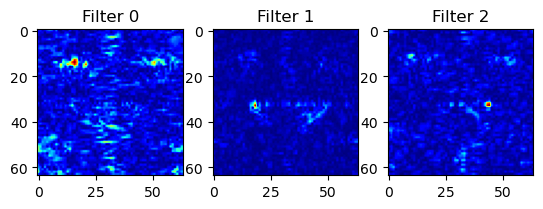

In [24]:
# print filters
plt.figure()
for i in range(len(filtres)):
    plt.subplot(1, 3, i + 1)
    fft_spec = np.abs(np.fft.fftshift(np.fft.fft2(filtres[i].reshape(unknown_img_gray.shape))))
    plt.imshow(fft_spec, cmap='jet')
    plt.title("Filter " + str(i))
plt.show()

Strmost vrcholu ve výsledném obraze počítejte ze střední oblasti 20x20 ve které je vrchol v oblasti 10x10.

- okolí (O) 20x20, 
- vrchol (V) 10x10
$$
RES_i= \frac{max(V) – mean(O (bez V))}{std(O (bez V))}
$$

In [25]:
def calculate_RES(img_fft: np.ndarray, suround_area_size: int = 20, peak_area_size: int = 10):
    """
    Strmost vrcholu ve výsledném obraze počítejte ze střední oblasti 20x20 ve které je vrchol v oblasti 10x10.
    """
    # prostredek obrazu
    x = img_fft.shape[1] // 2
    y = img_fft.shape[0] // 2

    suround_area_size = suround_area_size // 2
    peak_area_size = peak_area_size // 2
    
    # definice střední oblasti
    center_area = img_fft[y - peak_area_size : y + peak_area_size, x - peak_area_size : x + peak_area_size]

    # definice okolní oblasti
    suround_area = img_fft[y - suround_area_size : y + suround_area_size, x - suround_area_size : x + suround_area_size].copy()
    
    # odstranění střední oblasti z okolní oblasti
    x = suround_area.shape[1] // 2
    y = suround_area.shape[0] // 2
    suround_area[y - peak_area_size : y + peak_area_size, x - peak_area_size : x + peak_area_size] = 0

    # výpočet res
    res = (np.max(center_area) - np.mean(suround_area[suround_area != 0])) / np.std(suround_area[suround_area != 0])

    return res

unknown_fft: (4096,)
MACE filters: (4096, 1)


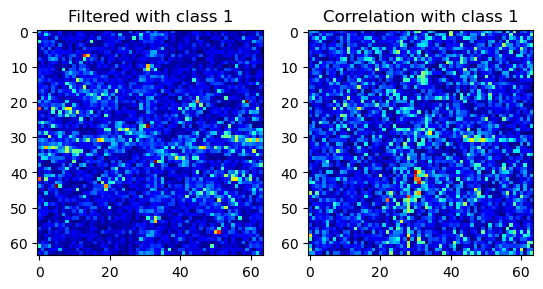

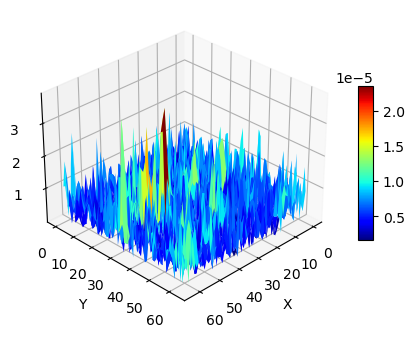

RES for class 1 : 3.6121915978671244


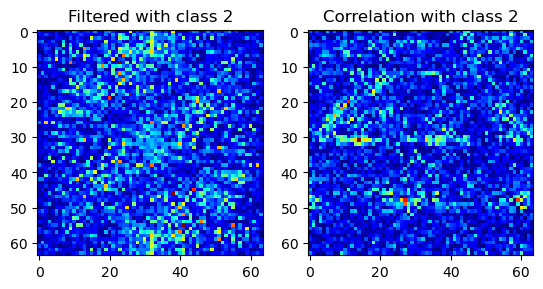

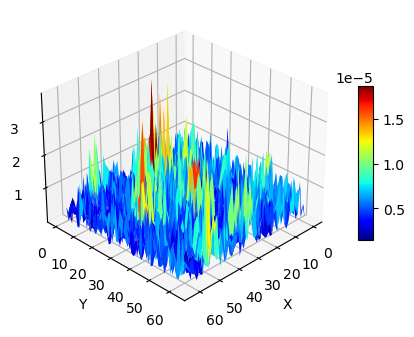

RES for class 2 : 4.626963937193008


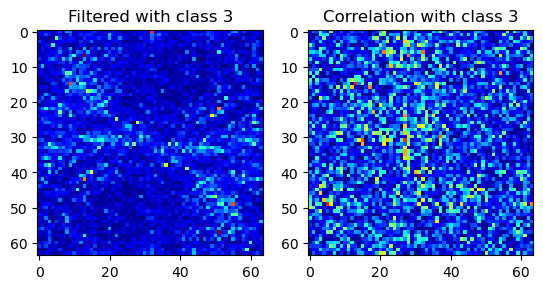

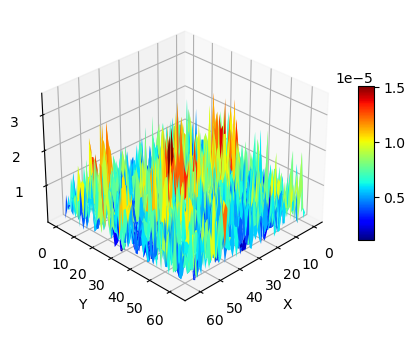

RES for class 3 : 3.9491807302350566
Class recognized:
 - index:  2


In [46]:
# Aplikace MACE filtru na neznámý obrázek
RES = []
unknown_fft = np.fft.fft2(unknown_img_gray).reshape(-1, 1).squeeze()
print("unknown_fft:", unknown_fft.shape)
print("MACE filters:", filtres[0].shape)
for i in range(number_of_classes):
    MACE_filter = filtres[i].squeeze()
    # filtrace
    filtered = (MACE_filter * unknown_fft).reshape(unknown_img_gray.shape)
    # zpětná Fourierova transformace
    correlation = np.abs(fft.shift(np.fft.ifft2(filtered)))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(np.abs(fft.shift(filtered)), cmap='jet')
    plt.title("Filtered with class " + str(i + 1))

    plt.subplot(1, 2, 2)
    plt.imshow(np.abs(correlation), cmap='jet')
    plt.title("Correlation with class " + str(i + 1))

    # 3D plot korelace
    x = np.arange(correlation.shape[0])
    y = np.arange(correlation.shape[1])
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, correlation.T, cmap='jet')  # Use your preferred color map
    ax.view_init(elev=30, azim=45)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Korelace")

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.show()

    res = calculate_RES(correlation)
    RES.append(res)
    print("RES for class", i + 1, ":", Blue + str(res) + NC)

# Výsledek, rozpoznání třídy
class_index = np.argmax(RES)
print(Green + "Class recognized:" + NC)
print(" - index: ", Blue + str(class_index + 1) + NC)

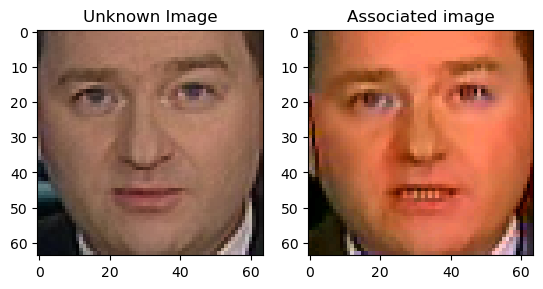

In [27]:
# Vyhodnocení výsledků
plt.subplot(1, 2, 1)
plt.imshow(unknown_image)
plt.title("Unknown Image")

plt.subplot(1, 2, 2)
# trida
plt.imshow(clases[class_index][0])
plt.title("Associated image")

plt.show()